### Dataset loader for the deep learning model training.

In [1]:
import cv2
import time
import torch
import random
import numpy as np 
from glob import glob
import rasterio as rio 
from notebooks import config
import matplotlib.pyplot as plt
from utils.imgShow import imsShow 
from torchvision.transforms import v2
from utils.data_aug import GaussianNoise
from utils.dataloader import read_scenes 
from utils.dataloader import SceneArraySet, PatchPathSet


In [2]:
patch_size = 512  ## patch size setting
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}/*'))  ## for model prediction 
print(f'vali patch: {len(paths_valset)}')


train scenes: 52
vali patch: 117


In [3]:
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                        paths_truth_tra, 
                                        paths_dem_tra)


In [4]:
transforms_tra = v2.Compose([
            v2.ToImage(),
            v2.RandomCrop(size=(patch_size, patch_size)),
            v2.RandomHorizontalFlip(p=0.3),
            v2.RandomVerticalFlip(p=0.3),
            v2.RandomRotation(degrees=180),
            GaussianNoise(mean = 0.0, sigma_max_img=0.1, 
                              sigma_max_dem=0, p=0.3) 
        ]) 
transforms_val = v2.Compose([
      v2.ToDtype(torch.float32),
       ])  

In [5]:
# Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                          truths_arr=truths_arr, 
                          patch_size=patch_size,
                          transforms=transforms_tra)
val_data = PatchPathSet(paths_valset=paths_valset, transforms=transforms_val)


torch.Size([7, 512, 512]) torch.Size([1, 512, 512])
training data size: 52
validation data size: 117


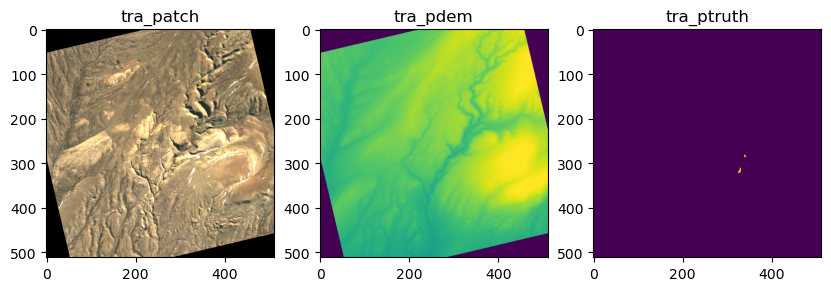

In [6]:
patch_pdem, ptruth = tra_data[1]
# print('patch_lat:', plat)
patch, dem = patch_pdem[:-1], patch_pdem[-1:]  ## last channel is dem
print(patch_pdem.shape, ptruth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([patch.numpy().astype(float).transpose((1, 2, 0)), dem.numpy().transpose((1, 2, 0)), ptruth[0].numpy()], 
              clip_list=[2,2,2], 
              img_name_list=['tra_patch','tra_pdem','tra_ptruth'], 
              figsize=(10, 3))


torch.Size([7, 512, 512]) torch.Size([1, 512, 512])
training data size: 52
validation data size: 117


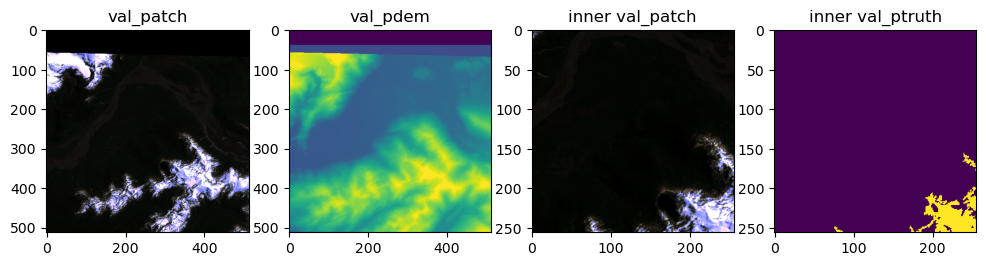

In [8]:
id = random.randint(0, len(val_data)-1)
patch_pdem, ptruth = val_data[id]
patch_pdem_ptruth = torch.cat([patch_pdem, ptruth], dim=0)
patch_pdem_ptruth_inner = v2.functional.center_crop(patch_pdem_ptruth, 256)
patch, dem = patch_pdem_ptruth[0:6], patch_pdem_ptruth[6:7]  ## last channel is dem
patch_inner, ptruth_inner = patch_pdem_ptruth_inner[0:6], patch_pdem_ptruth_inner[7:8]
# print('patch_lat:', plat)
print(patch_pdem.shape, ptruth.shape)
print('training data size:',len(tra_data))
print('validation data size:', len(val_data))
imsShow([patch.numpy().astype(float).transpose((1, 2, 0)), dem.numpy().transpose((1, 2, 0)), 
          patch_inner[:-1].numpy().transpose((1, 2, 0)), ptruth_inner.numpy().transpose((1, 2, 0))], 
              clip_list=[2,1,2,0], 
              img_name_list=['val_patch','val_pdem','inner val_patch','inner val_ptruth'], 
              figsize=(12, 3))


In [9]:
### Create DataLoader
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=5)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4,
                                         num_workers=5)


In [13]:
## check data loading time
time_start = time.time()
for x_batch, y_batch in tra_loader:
  print(f"traBatch processing time: {time.time() - time_start:.1f}")
time_start = time.time()  
## check data loading time
# time_start = time.time()
# for x_batch, y_batch in val_loader:
#   print(f"valBatch processing time: {time.time() - time_start:.1f}")
# time_start = time.time()   


traBatch processing time: 0.9
traBatch processing time: 0.9
traBatch processing time: 0.9
traBatch processing time: 0.9
traBatch processing time: 1.0
traBatch processing time: 1.3
traBatch processing time: 1.3
traBatch processing time: 1.3
traBatch processing time: 1.5
traBatch processing time: 1.5
traBatch processing time: 1.7
traBatch processing time: 1.7
traBatch processing time: 1.7


torch.Size([4, 7, 512, 512]) torch.Size([4, 1, 512, 512])


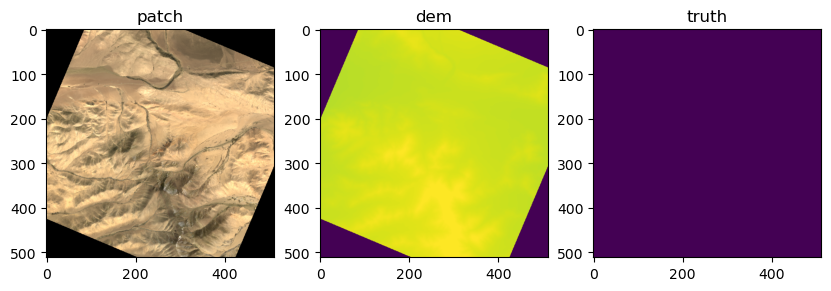

<Figure size 640x480 with 0 Axes>

In [17]:
# for patch, truth in tra_loader:
#     print(patch.shape)
batch_patch, batch_truth = next(iter(tra_loader))
print(batch_patch.shape, batch_truth.shape)
patch_arr = batch_patch[0].numpy().transpose((1, 2, 0))
dem_arr = batch_patch[0].numpy()[-1]
truth_arr = batch_truth[0].numpy().squeeze()
# print('lat:', batch_lat[0].item())
imsShow([patch_arr,  dem_arr, truth_arr],  
          color_bands_list=[[2,1,0], None, None],
          img_name_list=['patch', 'dem', 'truth'], 
          clip_list=[2,2,2], 
          figsize=(10, 3))
plt.tight_layout()
